In [2]:
!pip install git+https://github.com/KindXiaoming/pykan.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-3tgygz8u
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-3tgygz8u
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done


In [3]:
!pip install torch matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [7]:
pip install scikit-learn==1.1.3

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.1.1 requires scikit-learn>=1.4.2, but you have scikit-learn 1.1.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import matplotlib.pyplot as plt
from kan import *

In [5]:
!pip install mne
import mne

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install moabb

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
from mne.decoding import CSP
from mne import Epochs, pick_types, events_from_annotations
from kan import *
from kan import KAN
from kan import LBFGS
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss, Module

In [9]:
from torch.utils.data import DataLoader, TensorDataset
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')# if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
from tqdm import tqdm
import time
import json


epochs=20
batch = 16
lr = 0.1
loss_fn = CrossEntropyLoss()
steps=50
kf = KFold(n_splits=10, shuffle=True, random_state=42)
subjects= [1,2,3,4,5,6,7,8,9]
le = LabelEncoder()
hidden_layers= 10

moabb.set_log_level("info")
warnings.filterwarnings("ignore")
csp = CSP(n_components=4, reg='oas')
def data_EEG(subjects, train=True, multiclass=False):
        if train:
                session_name = "0train"

        else:
                session_name="1test"


        dataset = BNCI2014_001()

        if multiclass:
                event_id = dict(left=1, right=2, feet=3, tongue=4)
        else:
                event_id = dict(left=1, right=2)#, feet=3, tongue=4)

        tmin, tmax = -1., 6.
        runs = range(5)

        epochs_data=[]
        for subject in subjects:
                sessions = dataset.get_data(subjects=[subject])
                for run in runs:
                        raw = sessions[subject][session_name][str(run)]
                        events = mne.find_events(raw, stim_channel="stim")
                        picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
                        raw.filter(7., 35., method='iir', picks=picks)

                        epochs = Epochs(raw,
                                events,
                                event_id,
                                tmin,
                                tmax,
                                proj=True,
                                picks=picks,
                                baseline=None,
                                preload=True,
                                verbose=False)
                        epochs_data.append(epochs)
        return epochs_data

def export_json(data, filename):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            data[key] = value.tolist()
        elif isinstance(value, list) and all(isinstance(x, list) for x in value):  # Check if ALL items are lists
            data[key] = [[float(item) for item in sublist] for sublist in value]  # Convert inner elements to float
        elif isinstance(value, list):
            data[key] = [float(item) for item in value]  # Convert the numbers to float in the list


    with open(filename, "w") as outfile:
        json.dump(data, outfile, indent=4)
class KANModel(Module):
    def __init__(self, input_shape, output_shape, device='cpu'):
        super(KANModel, self).__init__()
        self.kan = KAN(width=[input_shape, output_shape], grid=3, k=3, seed=0, device=device)

        # Ensure all parameters are in double precision
        for param in self.kan.parameters():
            param.data = param.data.double()

    def forward(self, x):
        return self.kan(x)

    def train_model(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2.,
                    lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10,
                    stop_grid_update_step=50, batch=-1, loss_fn=None, lr=1.,
                    small_mag_threshold=1e-16, small_reg_factor=1., sglr_avoid=False):

        # Initialize progress bar
        pbar = tqdm(range(steps), desc='Training KAN', ncols=100)

        # Define loss function and accuracy metrics
        if loss_fn is None:
            loss_fn = lambda x, y: torch.mean((x - y) ** 2)
        acc = lambda x, y: torch.mean((torch.argmax(x, dim=1) == y).float())

        # Configure the optimizer
        if opt == "Adam":
            optimizer = optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe")

        results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
        else:
            batch_size = batch

        global train_loss, train_acc

        def closure():
            global train_loss, train_acc
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(self.kan.device))
            if sglr_avoid:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(self.kan.device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.kan.device))
            train_acc = acc(pred, dataset['train_label'][train_id].to(self.kan.device))

            objective = train_loss + lamb
            objective.backward()
            return objective

        for _ in pbar:
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size, replace=True)

            if opt == "LBFGS":
                optimizer.step(closure)
            else:
                pred = self.forward(dataset['train_input'][train_id].to(self.kan.device))
                if sglr_avoid:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(self.kan.device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.kan.device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn(self.forward(dataset['test_input'][test_id].to(self.kan.device)), dataset['test_label'][test_id].to(self.kan.device))
            test_acc = acc(self.forward(dataset['test_input'][test_id].to(self.kan.device)), dataset['test_label'][test_id].to(self.kan.device))

            if _ % log == 0:
                pbar.set_description("train acc: %.3f | test acc: %.3f " % (train_acc.cpu().detach().numpy(), test_acc.cpu().detach().numpy()))

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

        return results



In [10]:

class MLP(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),  # Activation function (you can experiment with others)
            Linear(hidden_dim, output_dim)  # Output layer
        )

    def forward(self, x):
        return self.layers(x)
    
    
    def initialize_from_another_model(self, model, data):
        """ Initialize the current model from another model using the data provided """
        # Assuming we are initializing the weights from another model
        self.kan.initialize_from(model.kan)
        return self


    def train(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        '''


        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        acc = acc_eval = lambda x,y: torch.mean((torch.argmax(x, dim=1) == y).float())

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['train_acc'] = []
        results['test_acc'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, train_acc

        def closure():
            global train_loss, train_acc
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            train_acc = acc(pred, dataset['train_label'][train_id].to(device))

            objective = train_loss + lamb
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:

            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            #if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
            #    self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))
            test_acc = acc_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

            if _ % log == 0:
                pbar.set_description("train acc: %.3f | test acc: %.3f " % ((train_acc).cpu().detach().numpy(), (test_acc).cpu().detach().numpy()))

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()

        return results

In [11]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.05e-01 | test_loss: 5.91e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:13<00:00,  3.76it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.42e-01 | test_loss: 5.26e-01 | reg: 9.89e+00 | : 100%|█| 50/50 [00:12<00:00,  3.86it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.10e-01 | test_loss: 4.74e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:12<00:00,  3.85it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.59e-01 | test_loss: 6.73e-01 | reg: 9.84e+00 | : 100%|█| 50/50 [00:13<00:00,  3.71it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.39e-01 | test_loss: 6.50e-01 | reg: 9.93e+00 | : 100%|█| 50/50 [00:13<00:00,  3.62it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.02e-01 | test_loss: 6.34e-01 | reg: 1.00e+01 | : 100%|█| 50/50 [00:13<00:00,  3.60it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.64e-01 | test_loss: 5.94e-01 | reg: 1.02e+01 | : 100%|█| 50/50 [00:14<00:00,  3.54it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.18e-01 | test_loss: 5.80e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:14<00:00,  3.51it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.07e-01 | test_loss: 6.06e-01 | reg: 1.04e+01 | : 100%|█| 50/50 [00:15<00:00,  3.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.99e-01 | test_loss: 6.10e-01 | reg: 1.04e+01 | : 100%|█| 50/50 [00:15<00:00,  3.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.74e-01 | test_loss: 5.75e-01 | reg: 1.06e+01 | : 100%|█| 50/50 [00:12<00:00,  4.03it


saving model version 0.1


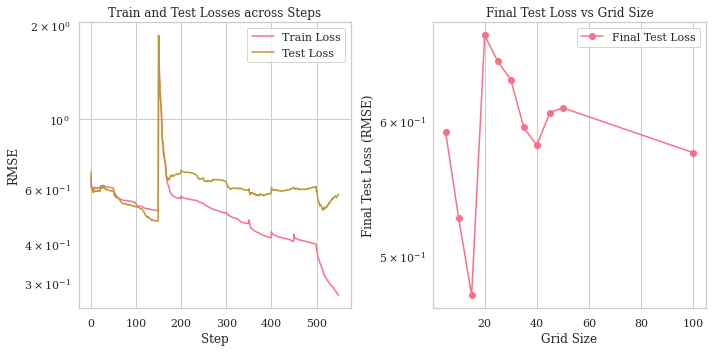

In [12]:
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.04e-01 | test_loss: 5.94e-01 | reg: 9.85e+00 | : 100%|█| 50/50 [00:13<00:00,  3.67it


saving model version 0.1


| train_loss: 6.00e-01 | test_loss: 5.92e-01 | reg: 1.00e+01 | : 100%|█| 50/50 [00:14<00:00,  3.36it


saving model version 0.2


| train_loss: 6.06e-01 | test_loss: 6.01e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:13<00:00,  3.57it


saving model version 0.3


| train_loss: 6.05e-01 | test_loss: 6.01e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:13<00:00,  3.65it


saving model version 0.4


| train_loss: 6.06e-01 | test_loss: 6.02e-01 | reg: 1.02e+01 | : 100%|█| 50/50 [00:11<00:00,  4.49it


saving model version 0.5


| train_loss: 6.05e-01 | test_loss: 6.01e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:11<00:00,  4.29it


saving model version 0.6


| train_loss: 6.06e-01 | test_loss: 6.02e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:10<00:00,  4.92it


saving model version 0.7


| train_loss: 6.04e-01 | test_loss: 5.98e-01 | reg: 1.04e+01 | : 100%|█| 50/50 [00:11<00:00,  4.43it


saving model version 0.8


| train_loss: 6.05e-01 | test_loss: 6.01e-01 | reg: 1.04e+01 | : 100%|█| 50/50 [00:11<00:00,  4.40it


saving model version 0.9


| train_loss: 6.05e-01 | test_loss: 6.01e-01 | reg: 1.05e+01 | : 100%|█| 50/50 [00:09<00:00,  5.37it


saving model version 0.10


| train_loss: 6.05e-01 | test_loss: 6.01e-01 | reg: 1.05e+01 | : 100%|█| 50/50 [00:08<00:00,  5.58it


saving model version 0.11


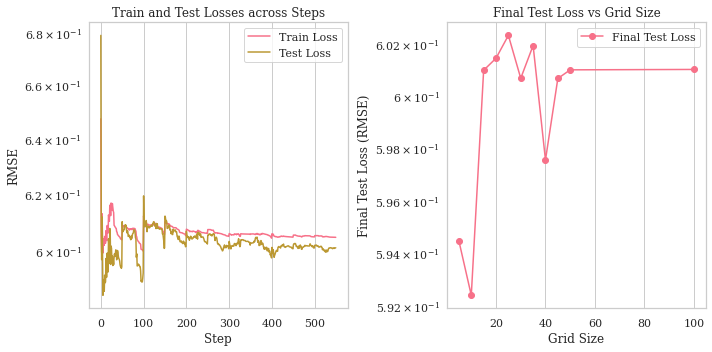

In [13]:
# commented initialize_from_another_model 
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
#     else:
#         model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.04e-01 | test_loss: 5.95e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:13<00:00,  3.73it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.42e-01 | test_loss: 5.19e-01 | reg: 9.80e+00 | : 100%|█| 50/50 [00:13<00:00,  3.68it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.31e-01 | test_loss: 4.59e-01 | reg: 6.86e+00 | : 100%|█| 50/50 [00:13<00:00,  3.79it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e-01 | test_loss: 4.11e-01 | reg: 6.80e+00 | : 100%|█| 50/50 [00:14<00:00,  3.51it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | test_loss: 4.65e-01 | reg: 6.82e+00 | : 100%|█| 50/50 [00:13<00:00,  3.69it


saving model version 0.1


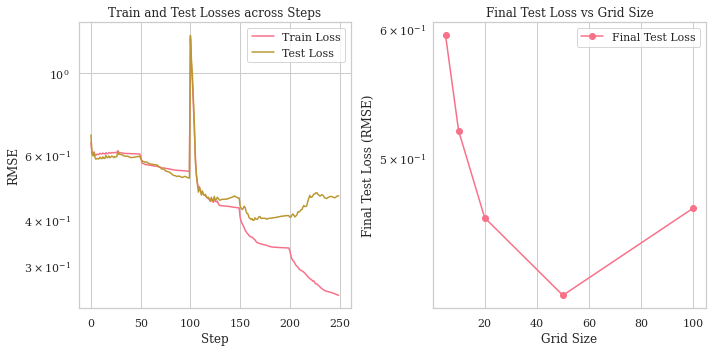

In [93]:
# only 5 grids 
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-03 | test_loss: 2.53e-03 | reg: 1.93e+01 | : 100%|█| 50/50 [00:14<00:00,  3.49it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.62e-04 | test_loss: 4.43e-04 | reg: 1.80e+01 | : 100%|█| 50/50 [00:15<00:00,  3.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.37e-05 | test_loss: 1.28e-04 | reg: 1.80e+01 | : 100%|█| 50/50 [00:11<00:00,  4.17it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.24e-05 | test_loss: 7.99e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:11<00:00,  4.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e-05 | test_loss: 6.47e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:08<00:00,  5.95it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.01e-05 | test_loss: 6.16e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:07<00:00,  6.96it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.69e-05 | test_loss: 5.97e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:09<00:00,  5.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.47e-05 | test_loss: 6.21e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:06<00:00,  7.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.29e-05 | test_loss: 5.99e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:07<00:00,  6.93it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.08e-05 | test_loss: 5.98e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:07<00:00,  6.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.67e-06 | test_loss: 7.63e-05 | reg: 1.80e+01 | : 100%|█| 50/50 [00:10<00:00,  4.91it


saving model version 0.1


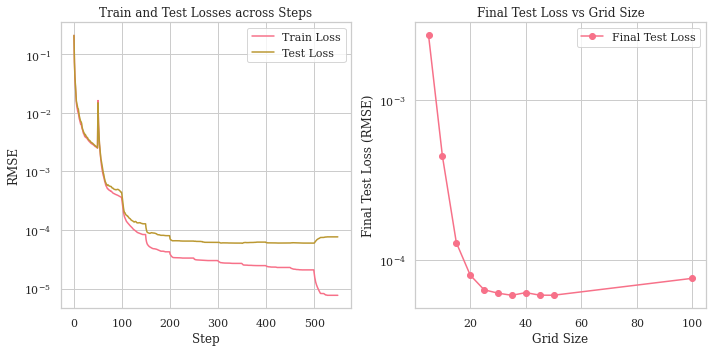

In [94]:
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.47e-03 | test_loss: 2.52e-03 | reg: 1.91e+01 | : 100%|█| 50/50 [00:13<00:00,  3.59it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.43e-04 | test_loss: 4.99e-04 | reg: 1.76e+01 | : 100%|█| 50/50 [00:15<00:00,  3.25it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.48e-05 | test_loss: 1.07e-04 | reg: 1.72e+01 | : 100%|█| 50/50 [00:13<00:00,  3.75it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-05 | test_loss: 6.68e-05 | reg: 1.72e+01 | : 100%|█| 50/50 [00:12<00:00,  3.96it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.79e-06 | test_loss: 8.69e-05 | reg: 1.72e+01 | : 100%|█| 50/50 [00:10<00:00,  4.55it


saving model version 0.1


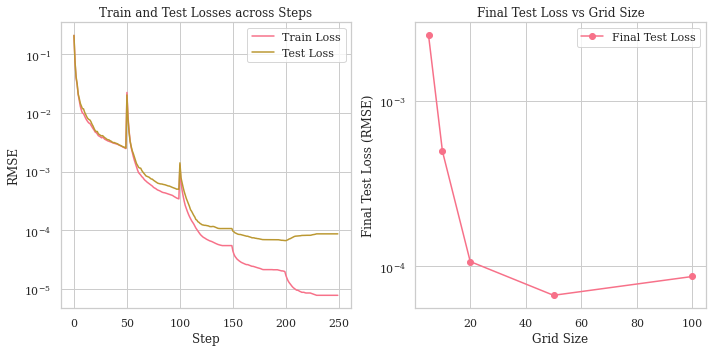

In [95]:
# only 5 grids
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.01e-01 | test_loss: 5.92e-01 | reg: 1.06e+01 | : 100%|█| 50/50 [00:12<00:00,  3.93it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.48e-01 | test_loss: 5.28e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:13<00:00,  3.80it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.11e-01 | test_loss: 5.17e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:13<00:00,  3.78it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.13e-01 | test_loss: 4.30e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:14<00:00,  3.54it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.54e-01 | test_loss: 3.92e-01 | reg: 1.02e+01 | : 100%|█| 50/50 [00:13<00:00,  3.74it


saving model version 0.1


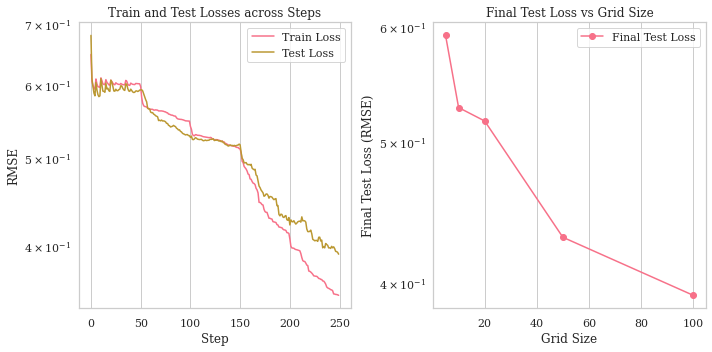

In [96]:
# only 5 grids and stop_grid_update_step=50
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=50)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.01e-01 | test_loss: 5.91e-01 | reg: 9.22e+00 | : 100%|█| 50/50 [00:13<00:00,  3.84it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.25e-01 | test_loss: 4.87e-01 | reg: 8.79e+00 | : 100%|█| 50/50 [00:14<00:00,  3.49it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.57e-01 | test_loss: 4.56e-01 | reg: 8.98e+00 | : 100%|█| 50/50 [00:13<00:00,  3.79it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.59e-01 | test_loss: 3.77e-01 | reg: 8.94e+00 | : 100%|█| 50/50 [00:13<00:00,  3.61it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | test_loss: 3.38e-01 | reg: 9.10e+00 | : 100%|█| 50/50 [00:13<00:00,  3.67it


saving model version 0.1


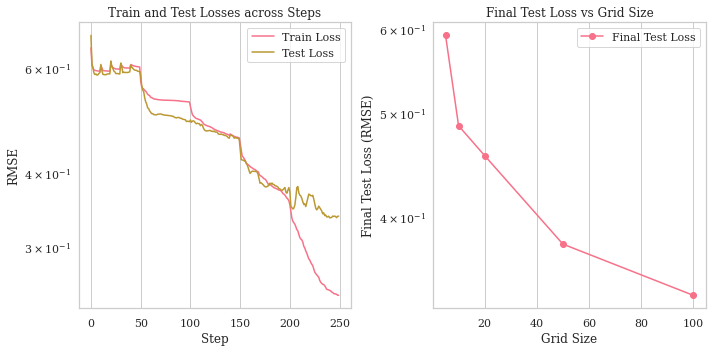

In [97]:
# only 5 grids and stop_grid_update_step=50
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=100)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.93e-01 | test_loss: 6.05e-01 | reg: 9.53e+00 | : 100%|█| 50/50 [00:12<00:00,  4.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.32e-01 | test_loss: 5.05e-01 | reg: 8.92e+00 | : 100%|█| 50/50 [00:12<00:00,  4.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.91e-01 | test_loss: 4.51e-01 | reg: 8.83e+00 | : 100%|█| 50/50 [00:12<00:00,  3.87it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.02e-01 | test_loss: 4.25e-01 | reg: 8.88e+00 | : 100%|█| 50/50 [00:13<00:00,  3.58it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.45e-01 | test_loss: 3.54e-01 | reg: 8.93e+00 | : 100%|█| 50/50 [00:12<00:00,  3.97it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.27e-01 | test_loss: 3.49e-01 | reg: 8.95e+00 | : 100%|█| 50/50 [00:13<00:00,  3.81it


saving model version 0.1


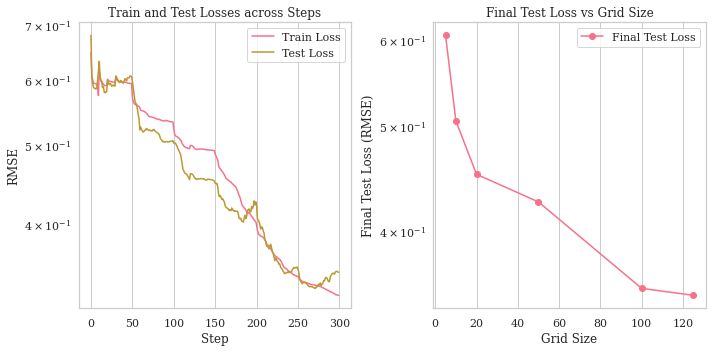

In [98]:
# only 6 grids and stop_grid_update_step=100
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100, 125])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=100)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.05e-01 | test_loss: 5.99e-01 | reg: 1.03e+01 | : 100%|█| 50/50 [00:12<00:00,  3.97it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.46e-01 | test_loss: 5.31e-01 | reg: 1.00e+01 | : 100%|█| 50/50 [00:13<00:00,  3.72it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.99e-01 | test_loss: 4.71e-01 | reg: 1.00e+01 | : 100%|█| 50/50 [00:13<00:00,  3.78it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.62e-04 | test_loss: 3.49e-04 | reg: 9.06e+00 | : 100%|█| 50/50 [00:14<00:00,  3.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.63e-05 | test_loss: 6.27e-05 | reg: 9.06e+00 | : 100%|█| 50/50 [00:08<00:00,  5.90it


saving model version 0.1


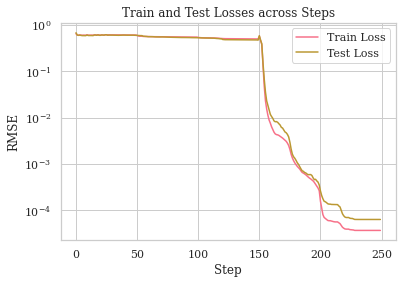

In [19]:
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']

# Plot the train and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

# Set labels and title
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')  # Log scale for better visualization of large loss variations
plt.title('Train and Test Losses across Steps')

# Display the plot
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.02e-01 | test_loss: 5.93e-01 | reg: 1.01e+01 | : 100%|█| 50/50 [00:16<00:00,  2.97it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.44e-01 | test_loss: 5.30e-01 | reg: 9.77e+00 | : 100%|█| 50/50 [00:15<00:00,  3.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.04e+00 | test_loss: 1.08e+00 | reg: 7.58e+00 | : 100%|█| 50/50 [00:14<00:00,  3.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.70e-01 | test_loss: 8.98e-01 | reg: 8.84e+00 | : 100%|█| 50/50 [00:14<00:00,  3.55it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 9.17e+00 | : 100%|█| 50/50 [00:13<00:00,  3.77it


saving model version 0.1


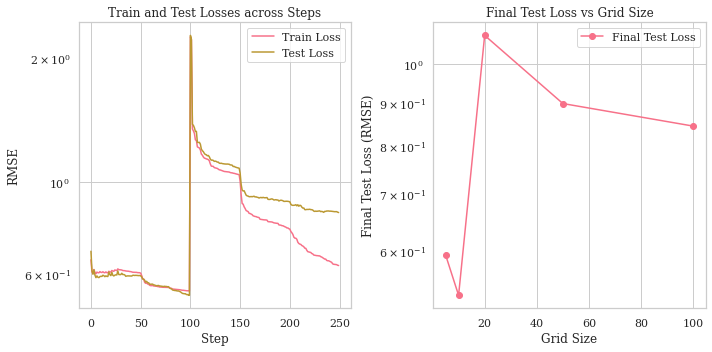

In [22]:
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
final_test_losses = []  # Store the final test loss for each grid size
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 1, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    
    # Record the final test loss for the current grid size
    final_test_losses.append(results['test_loss'][-1])

# Plot the train and test losses across all steps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Train and Test Losses across Steps')

# Plot test loss vs grid size
plt.subplot(1, 2, 2)
plt.plot(grids, final_test_losses, marker='o', label='Final Test Loss')
plt.xlabel('Grid Size')
plt.ylabel('Final Test Loss (RMSE)')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.title('Final Test Loss vs Grid Size')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.70e-03 | test_loss: 2.76e-03 | reg: 1.91e+01 | : 100%|█| 50/50 [00:14<00:00,  3.47it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.41e-04 | test_loss: 5.50e-04 | reg: 1.76e+01 | : 100%|█| 50/50 [00:15<00:00,  3.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.88e-05 | test_loss: 7.47e-05 | reg: 1.76e+01 | : 100%|█| 50/50 [00:12<00:00,  3.85it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-05 | test_loss: 5.91e-05 | reg: 1.76e+01 | : 100%|█| 50/50 [00:10<00:00,  4.92it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.90e-06 | test_loss: 6.84e-05 | reg: 1.76e+01 | : 100%|█| 50/50 [00:10<00:00,  4.73it


saving model version 0.1


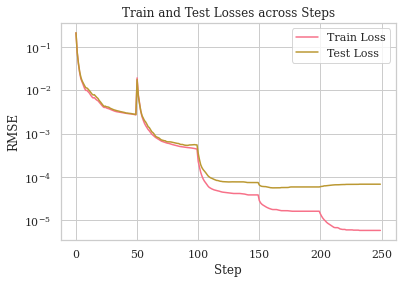

In [20]:
import numpy as np
import matplotlib.pyplot as plt

grids = np.array([5, 10, 20, 50, 100])  # Grid sizes to experiment with

train_losses = []
test_losses = []
steps = 50
k = 3

# Initialize the model and train it for different grid sizes
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k)  # Initialize the first model
    else:
        model = KAN(width=[2, 5, 1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])  # Reinitialize from previous model

    # Train the model and store the results
    results = model.fit(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    
    # Append train and test losses from the current model
    train_losses += results['train_loss']
    test_losses += results['test_loss']

# Plot the train and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

# Set labels and title
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.yscale('log')  # Log scale for better visualization of large loss variations
plt.title('Train and Test Losses across Steps')

# Display the plot
plt.show()
